In [ ]:
!pip install -q kaggle wordcloud

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bobibarua","key":"b348c0290d9fd976334d36f599c8103b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/41.0M [00:00<?, ?B/s]
100% 41.0M/41.0M [00:00<00:00, 1.14GB/s]


In [ ]:
!unzip -o fake-and-real-news-dataset.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

In [ ]:
fake_df['label'] = 0  # Fake
true_df['label'] = 1  # True

In [ ]:
fake_df = fake_df.drop_duplicates()

In [ ]:
true_df = true_df.drop_duplicates()

In [ ]:
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
df.tail()

,title,text,subject,date,label
44684,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44685,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44686,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44687,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
44688,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [ ]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


#**Dataset text cleaning**

In [ ]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape[0])

After removing duplicates: 44689


In [ ]:
print("Total samples:", len(df))
print("Fake samples:", (df['label']==0).sum())
print("True samples:", (df['label']==1).sum())

Total samples: 44689
Fake samples: 23478
True samples: 21211


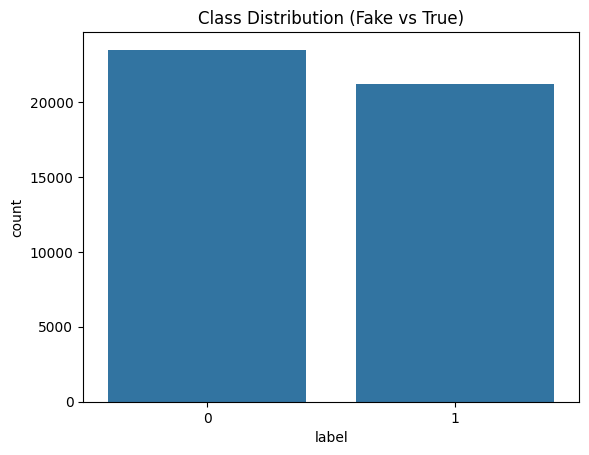

In [ ]:
sns.countplot(x='label', data=df)
plt.title("Class Distribution (Fake vs True)")
plt.show()


In [ ]:
print(df['subject'].value_counts())

subject
politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


In [ ]:
print(df['text'][0][:500])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a gr


In [ ]:
df = df.drop(columns=['subject', 'date'], errors='ignore')

In [ ]:
df.head()

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [ ]:
# Empty strings or whitespace-only
empty_text = (df['text'].str.strip() == "").sum()
print("Empty text rows:", empty_text)

Empty text rows: 631


In [ ]:
empty_text_rows = df[df['text'].str.strip() == ""]

print(empty_text_rows.tail())


                                                   title text  label
21823  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...           0
21824  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...           0
21854  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...           0
21870  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...           0
32402                     Graphic: Supreme Court roundup           1


In [ ]:
# Dropping empty/whitespace-only text rows
df = df[df['text'].str.strip() != ""].reset_index(drop=True)
print("New dataset shape:", df.shape)


New dataset shape: (44058, 3)


In [ ]:
print("Fake samples:", (df['label']==0).sum())
print("True samples:", (df['label']==1).sum())

Fake samples: 22848
True samples: 21210


In [ ]:
#text cleaning
df['text'] = df['text'].str.replace(r'^.*?[-:]\s+', '', regex=True)
df['text'] = df['text'].str.replace(r'https?://\S+', '', regex=True)
df['text'] = df['text'].str.replace(r'Featured Image:.*', '', regex=True)
df['text'] = df['text'].str.replace(r'featured image.*', '', flags=re.IGNORECASE, regex=True)
df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+|@\w+', '', regex=True)
df['text'] = df['text'].apply(lambda x: re.sub(r'\b\d+(?![%$]| million| billion)\b', '<NUM>', x, flags=re.IGNORECASE))
df['text'] = df['text'].str.replace(r'\([^\)]*\)', '', regex=True)
df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
df['text'] = df['text'].str.replace(r'(here\'s the video:|image via|pic\.twitter\.com/\S+)', '', flags=re.IGNORECASE, regex=True)
df['text'] = df['text'].apply(lambda x: ' '.join(
    s for s in re.split(r'(?<=[.!?])\s+', x)
    if not (re.search(r'(watch|video|statement|see)', s, re.IGNORECASE) and s.strip().endswith(':'))
))


In [ ]:
print(df['text'].iloc[42000])

Russian Foreign Minister Sergei Lavrov told his Iraqi counterpart Ibrahim al-Jaafari that Moscow supported Iraq s territorial integrity and sovereignty, the Russian Foreign Ministry said on Friday. Iraqi Kurds are expected to vote on Monday to back an independence drive that neighboring countries and Western powers fear could break up the country and stir broader regional ethnic and sectarian conflict. The Russian side confirmed its constant support for the unity, sovereignty and territorial integrity of Iraq,  the ministry said in a statement. 


In [ ]:
df['title'] = df['title'].str.replace(r'\([A-Z]+\)', '', regex=True)
df['title'] = df['title'].str.replace(r'^(WATCH:|Exclusive:|Highlights:)\s*', '', regex=True, flags=re.IGNORECASE)
df['title'] = df['title'].str.strip()

In [ ]:
print(df['title'].iloc[21823])

US admits not targeting Al Nusra, then blames Moscow for separating ‘moderates’ from terrorists


In [ ]:
#Combining title and text
df['full_text'] = df['title'] + ' ' + df['text']

In [ ]:
df['full_text'] = df['full_text'].str.lower()
df['full_text'] = df['full_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df['full_text'] = df['full_text'].apply(
    lambda x: re.sub(r'\b([A-Za-z])\.(?=[A-Za-z]\.)', r'\1<PERIOD>', x)
)

df['full_text'] = df['full_text'].str.replace(r'https?://\S+|www\.\S+|@\w+', '', regex=True)
df['full_text'] = df['full_text'].str.replace(
    r'(featured image:.*|here\'s the video:.*|pic\.twitter\.com/\S+)', '',
    flags=re.IGNORECASE, regex=True
)
df['full_text'] = df['full_text'].str.replace(r'\([^\)]*\)', '', regex=True)
df['full_text'] = df['full_text'].str.replace(r'#\w+', '', regex=True)
df['full_text'] = df['full_text'].apply(lambda x: re.sub(
    r'\b\d+(?![%$]| million| billion)\b', '<NUM>', x, flags=re.IGNORECASE
))

df['full_text'] = df['full_text'].apply(lambda x: ' '.join(
    s for s in re.split(r'(?<=[.!?])\s+', x)
    if not (re.search(r'(watch|video|statement|see)', s, re.IGNORECASE) and s.strip().endswith(':'))
))

df['full_text'] = df['full_text'].str.replace('<PERIOD>', '.', regex=False)

df['full_text'] = df['full_text'].str.replace(r'\s+', ' ', regex=True).str.strip()


In [ ]:
df.head()

,title,text,label,full_text
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,0,donald trump sends out embarrassing new year’s...
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,0,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke ...,"Immigration December <NUM>, 2017 Pendulum ...",0,sheriff david clarke becomes an internet joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"Unlike Obama, we are working to fix the proble...",0,trump is so obsessed he even has obama’s name ...
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,0,pope francis just called out donald trump duri...


In [ ]:
print("Duplicate texts in df:", df['full_text'].duplicated().sum())

Duplicate texts in df: 5431


In [ ]:
df = df.drop_duplicates(subset=['full_text']).reset_index(drop=True)

In [ ]:
print("Duplicate texts after cleaning:", df['full_text'].duplicated().sum())
print("Duplicate rows after cleaning:", df.duplicated().sum())

Duplicate texts after cleaning: 0
Duplicate rows after cleaning: 0


In [ ]:
print("Number of samples:", len(df))
print("Number of fake samples:", (df['label']==0).sum())
print("Number of true samples:", (df['label']==1).sum())

Number of samples: 38627
Number of fake samples: 17433
Number of true samples: 21194


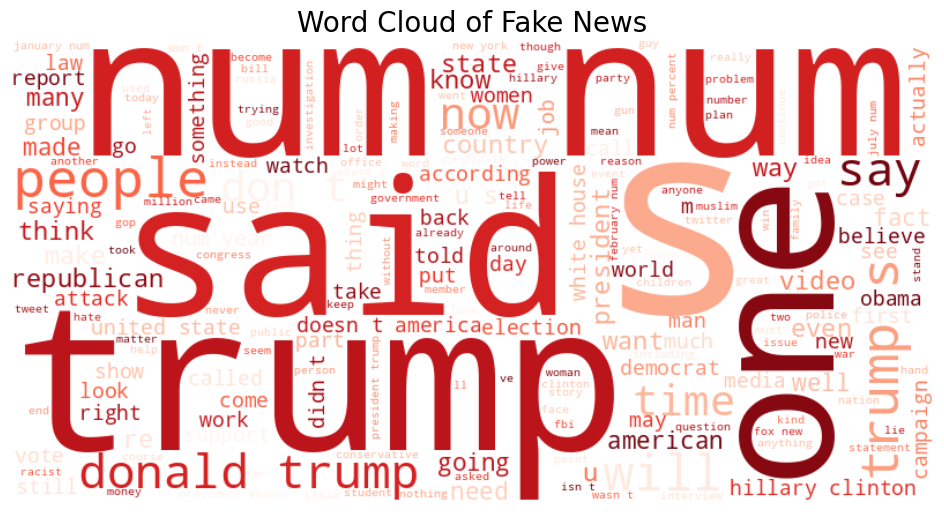

In [ ]:
# Word cloud for Fake news
fake_text = ' '.join(df[df['label']==0]['full_text'])
wordcloud_fake = WordCloud(width=800, height=400,
                           background_color='white',
                           max_words=200,
                           colormap='Reds').generate(fake_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Fake News", fontsize=20)
plt.show()

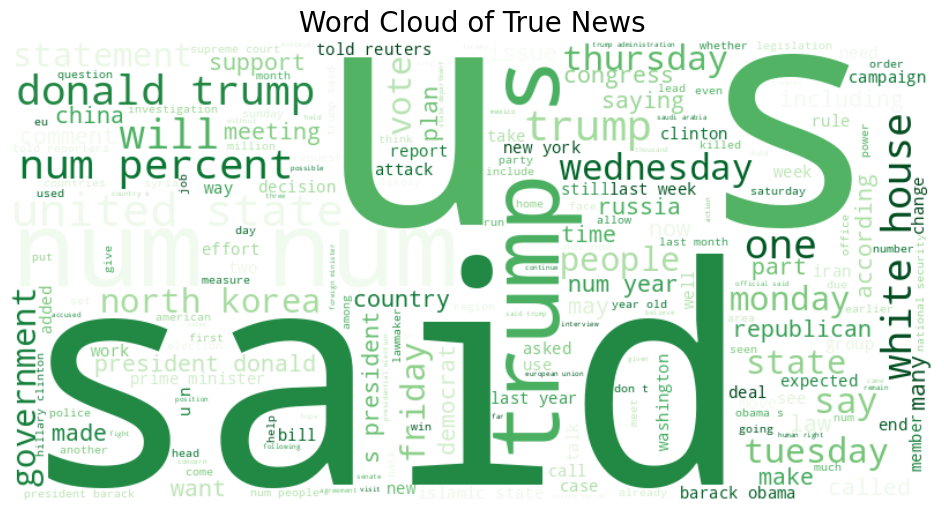

In [ ]:
# Word cloud for True news
true_text = ' '.join(df[df['label']==1]['full_text'])
wordcloud_true = WordCloud(width=800, height=400,
                           background_color='white',
                           max_words=200,
                           colormap='Greens').generate(true_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of True News", fontsize=20)
plt.show()

##**Model Hyperparameters**

In [ ]:
MAX_WORDS = 20000
MAX_LEN = 300
EMBEDDING_DIM = 100
BATCH_SIZE = 128
EPOCHS = 10
DROPOUT_RATE = 0.5


##**Train-Test Split**

In [ ]:
X = df['full_text']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Train samples: 30901
Test samples: 7726


#**Machine Learning Model Implementation**

In [ ]:
tfidf = TfidfVectorizer(max_features=50000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [ ]:
# Computing class weights for imbalance
classes = np.unique(y_train)
class_weights = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train)))

##**Logistic Regression**

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight=class_weights)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")

Logistic Regression Accuracy: 0.9810


In [ ]:
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3487
           1       0.98      0.99      0.98      4239

    accuracy                           0.98      7726
   macro avg       0.98      0.98      0.98      7726
weighted avg       0.98      0.98      0.98      7726



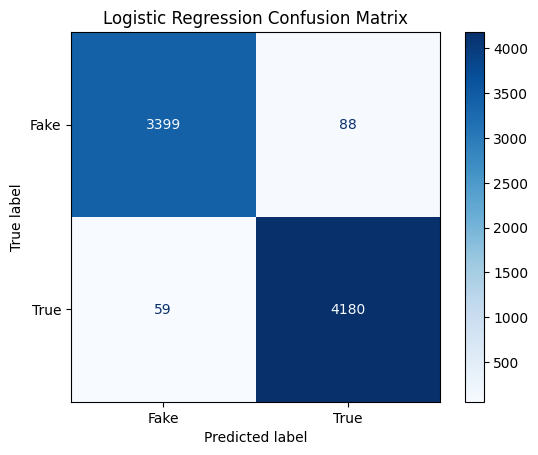

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm_lr, display_labels=["Fake", "True"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(lr, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']

##**Naive Bayes**

In [ ]:
#Naive Bayes
sample_weight = np.array([class_weights[y] for y in y_train])
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
y_pred_nb = nb.predict(X_test_tfidf)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")

Naive Bayes Accuracy: 0.9458


In [ ]:
print("Naive Bayes")
print(classification_report(y_test, y_pred_nb))

Naive Bayes
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3487
           1       0.95      0.96      0.95      4239

    accuracy                           0.95      7726
   macro avg       0.95      0.94      0.95      7726
weighted avg       0.95      0.95      0.95      7726



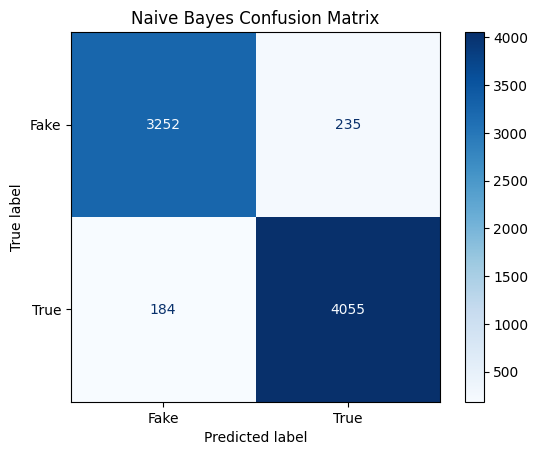

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(cm_nb, display_labels=["Fake", "True"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(nb, "naive_bayes_model.pkl")


['naive_bayes_model.pkl']

##**Random Forest**

In [ ]:
#Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight=class_weights, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

Random Forest Accuracy: 0.9663


In [ ]:
print("Random Forest")
print(classification_report(y_test, y_pred_rf))

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3487
           1       0.95      0.99      0.97      4239

    accuracy                           0.97      7726
   macro avg       0.97      0.96      0.97      7726
weighted avg       0.97      0.97      0.97      7726



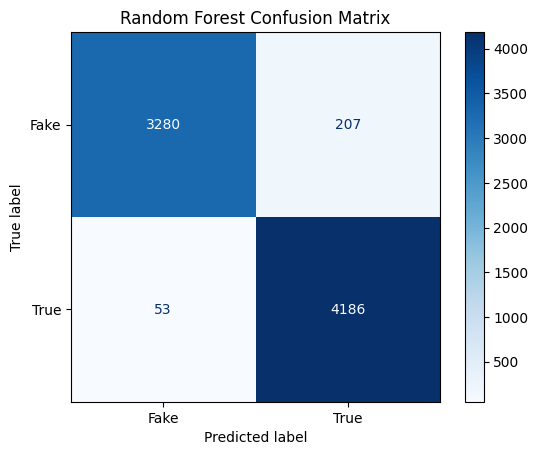

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm_rf, display_labels=["Fake", "True"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(rf, "random_forest_model.pkl")


['random_forest_model.pkl']

#**Deep Learning Model Implementation**

In [ ]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [ ]:
print("Training shape:", X_train_pad.shape)
print("Testing shape:", X_test_pad.shape)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
joblib.dump(tokenizer, "tokenizer.pkl")

['tokenizer.pkl']

###GloVe Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-10-16 07:12:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-16 07:12:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-16 07:12:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_path = "glove.6B.100d.txt"

In [ ]:
embedding_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeff

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

##**Plotting Curves**

In [ ]:
def plot_history(history, model_name):
    # Accuracy
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


###**LSTM**

In [ ]:
model__lstm = Sequential([
    Embedding(input_dim=MAX_WORDS,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),
    LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model__lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history__lstm = model__lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 195s 988ms/step - accuracy: 0.7815 - loss: 0.4526 - val_accuracy: 0.8673 - val_loss: 0.3320
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 985ms/step - accuracy: 0.9005 - loss: 0.2596 - val_accuracy: 0.9421 - val_loss: 0.1629
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 200s 978ms/step - accuracy: 0.9284 - loss: 0.1889 - val_accuracy: 0.9660 - val_loss: 0.0979
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 189s 976ms/step - accuracy: 0.9469 - loss: 0.1474 - val_accuracy: 0.9702 - val_loss: 0.0886
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 189s 976ms/step - accuracy: 0.9584 - loss: 0.1198 - val_accuracy: 0.9764 - val_loss: 0.0670
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 976ms/step - accuracy: 0.9664 - loss: 0.0948 - val_accuracy: 0.9822 - val_loss: 0.0542
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 193s 990ms/step - accuracy: 0.9719 - loss: 0.0812 - val_accuracy: 0.9833 - val_loss: 0.0466
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9759 - lo

In [ ]:
loss, acc = model__lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Test Accuracy: {acc:.4f}")

242/242 ━━━━━━━━━━━━━━━━━━━━ 47s 193ms/step - accuracy: 0.9864 - loss: 0.0362
LSTM Test Accuracy: 0.9881


In [ ]:
y_pred_prob = model__lstm.predict(X_test_pad)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_class))

242/242 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3487
           1       0.99      0.99      0.99      4239

    accuracy                           0.99      7726
   macro avg       0.99      0.99      0.99      7726
weighted avg       0.99      0.99      0.99      7726



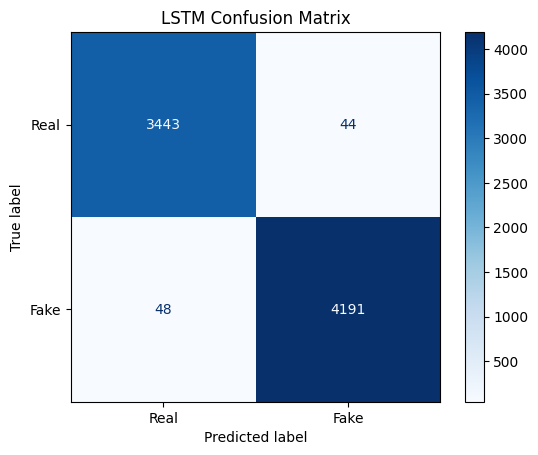

In [ ]:
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix")
plt.show()

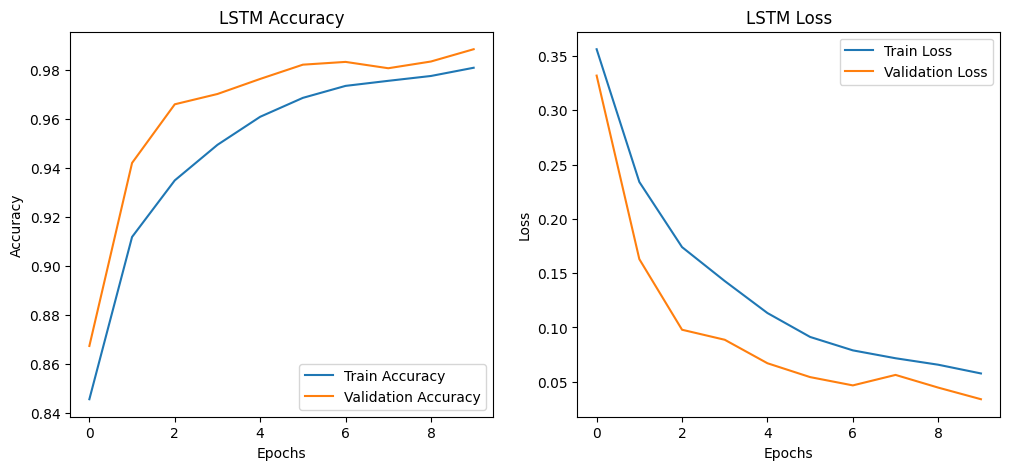

In [ ]:
plot_history(history__lstm, "LSTM")

In [ ]:
model__lstm.save("model__lstm.h5")

##**BiLSTM**

In [ ]:
model__bilstm = Sequential([
    Embedding(input_dim=MAX_WORDS,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model__bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history_bilstm = model__bilstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.7991 - loss: 0.4208 - val_accuracy: 0.9401 - val_loss: 0.1668
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9195 - loss: 0.2195 - val_accuracy: 0.9502 - val_loss: 0.1385
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.9406 - loss: 0.1596 - val_accuracy: 0.9573 - val_loss: 0.1205
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9526 - loss: 0.1356 - val_accuracy: 0.9673 - val_loss: 0.0920
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9631 - loss: 0.1038 - val_accuracy: 0.9790 - val_loss: 0.0600
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.9733 - loss: 0.0846 - val_accuracy: 0.9833 - val_loss: 0.0495
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9744 - loss: 0.0755 - val_accuracy: 0.9811 - val_loss: 0.0496
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9794 - loss: 0.0626 - val_accu

In [ ]:
loss, acc = model__bilstm.evaluate(X_test_pad, y_test)
print(f"BiLSTM Test Accuracy: {acc:.4f}")

242/242 ━━━━━━━━━━━━━━━━━━━━ 84s 348ms/step - accuracy: 0.9875 - loss: 0.0319
BiLSTM Test Accuracy: 0.9884


In [ ]:
y_pred_prob = model__bilstm.predict(X_test_pad)
y_pred_class = (y_pred_prob > 0.5).astype(int)
print("BiLSTM Classification Report:")
print(classification_report(y_test, y_pred_class))

242/242 ━━━━━━━━━━━━━━━━━━━━ 85s 348ms/step
BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3487
           1       0.99      0.99      0.99      4239

    accuracy                           0.99      7726
   macro avg       0.99      0.99      0.99      7726
weighted avg       0.99      0.99      0.99      7726



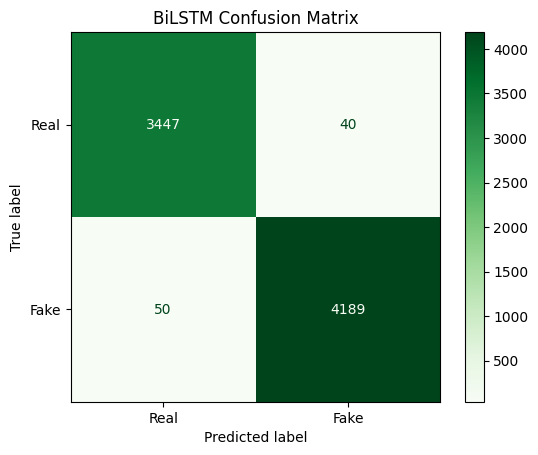

In [ ]:
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Greens)
plt.title("BiLSTM Confusion Matrix")
plt.show()

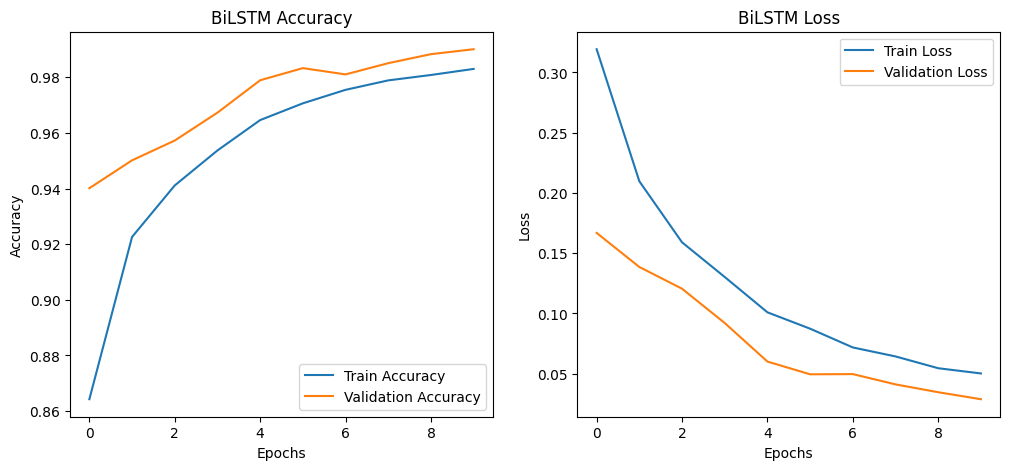

In [ ]:
plot_history(history_bilstm, "BiLSTM")

In [ ]:
model__bilstm.save("model__bilstm.h5")

##**GRU**

In [ ]:
model__gru = Sequential([
    Embedding(input_dim=MAX_WORDS,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),
    GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

model__gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history__gru = model__gru.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 183s 924ms/step - accuracy: 0.7763 - loss: 0.4572 - val_accuracy: 0.9201 - val_loss: 0.2069
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 172s 887ms/step - accuracy: 0.9376 - loss: 0.1704 - val_accuracy: 0.9625 - val_loss: 0.0945
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 171s 881ms/step - accuracy: 0.9625 - loss: 0.1083 - val_accuracy: 0.9798 - val_loss: 0.0510
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 881ms/step - accuracy: 0.9730 - loss: 0.0772 - val_accuracy: 0.9866 - val_loss: 0.0371
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 171s 881ms/step - accuracy: 0.9795 - loss: 0.0545 - val_accuracy: 0.9903 - val_loss: 0.0282
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 169s 873ms/step - accuracy: 0.9813 - loss: 0.0536 - val_accuracy: 0.9880 - val_loss: 0.0352
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 171s 882ms/step - accuracy: 0.9838 - loss: 0.0455 - val_accuracy: 0.9921 - val_loss: 0.0229
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 169s 872ms/step - accuracy: 0.9864 -

In [ ]:
loss, acc = model__gru.evaluate(X_test_pad, y_test)
print(f"GRU Test Accuracy: {acc:.4f}")

242/242 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.9925 - loss: 0.0226
GRU Test Accuracy: 0.9916


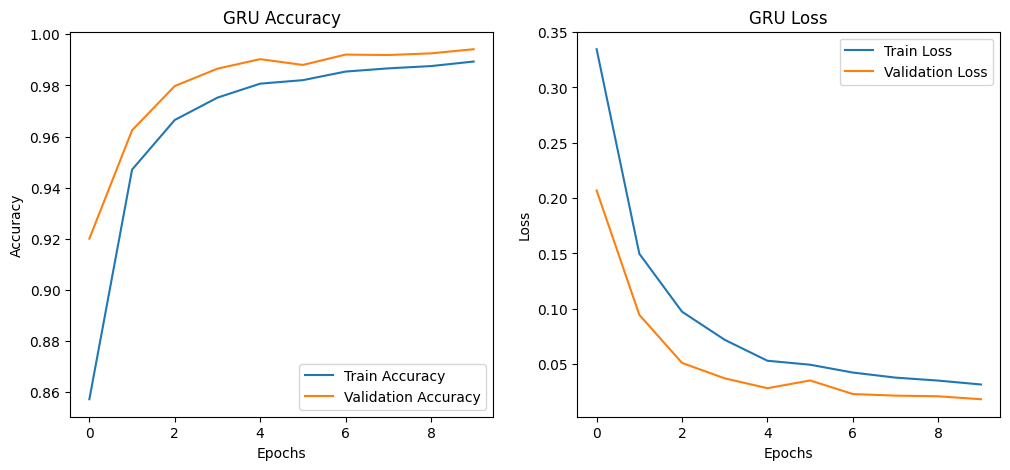

In [ ]:
plot_history(history__gru, "GRU")

In [ ]:
y_pred_prob__gru = model__gru.predict(X_test_pad)
y_pred_class__gru = (y_pred_prob__gru > 0.5).astype(int)

print("GRU Classification Report:")
print(classification_report(y_test, y_pred_class__gru))

242/242 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step
GRU Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3487
           1       0.99      0.99      0.99      4239

    accuracy                           0.99      7726
   macro avg       0.99      0.99      0.99      7726
weighted avg       0.99      0.99      0.99      7726



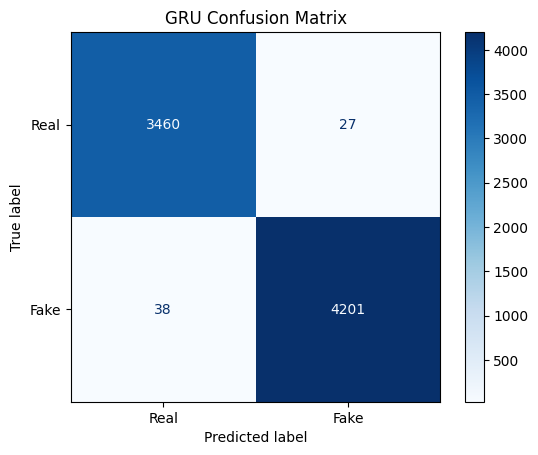

In [ ]:
cm = confusion_matrix(y_test, y_pred_class__gru)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("GRU Confusion Matrix")
plt.show()

In [ ]:
model__gru.save("model__gru.h5")

##**Others**

In [ ]:
label_map = {"Fake": 0, "True": 1}
with open("label_map.json", "w") as f:
    json.dump(label_map, f)

print("Label mapping saved")


Label mapping saved


In [ ]:
metadata = {
    "MAX_WORDS": MAX_WORDS,
    "MAX_LEN": MAX_LEN,
    "EMBEDDING_DIM": EMBEDDING_DIM,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "DROPOUT_RATE": DROPOUT_RATE
}

with open("model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("Model metadata saved")


Model metadata saved
